# Analyses of extremes

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
import os
import seaborn as sns
from scipy.stats import linregress
from scipy import stats
from dask import delayed
from IPython.display import display, HTML
import imageio
#from joblib import Parallel, delayed
import matplotlib.dates as mdates
import intake
from DV8_extremes import *
#DV8_functions(1) packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FFMpegWriter
from matplotlib import animation, rc
from IPython.display import HTML
#my functions:


import matplotlib.colors as mcolors

from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
import dask
from dask.distributed import Client, LocalCluster
import bokeh
import subprocess
import re

import warnings
#warnings.filterwarnings('ignore')


In [2]:


dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32,threads_per_worker=1)
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:40247' processes=32 threads=32, memory=250.00 GiB>

2025-11-10 18:09:27,770 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:35341 (pid=2361357) exceeded 95% memory budget. Restarting...
2025-11-10 18:09:30,143 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:35341' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('transpose-5dfbaec6291cdee2af4284b7fa66ae36', 22, 0, 0), ('astype-a2ee24243ab0fb99d7f5c960cbf24e61', 36, 0, 0)} (stimulus_id='handle-worker-cleanup-1762794570.1428945')
2025-11-10 18:09:30,167 - distributed.nanny - WARNING - Restarting worker
2025-11-10 18:11:03,119 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:33679 (pid=2361348) exceeded 95% memory budget. Restarting...
2025-11-10 18:11:04,698 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:33679' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('transpose-7fe5f31ca4421f2635a7c29a25682a48', 40, 0, 0), ('transpose-7fe5f31ca4

# LOAD DATA
### Only take latitudes between 50°S and 70°N, to retain only ice-free oceans. To make sure no sea ice appears in these latitudes we apply SSTA=SSTA.where(sst>-1.7) for all anomalies. Gridcells with sea ice are defined in OSTIA,ICON and IFS-FESOM as an SST value of ~-1.75, by applying the where condition we make sure to only take ice free times and grid-cells without throwing out entire areas, but only the times and places where sea ice appears.
### Convert ICON and IFS-FESOM longitudes from 0->360 to -180->180

In [3]:

def lon_180w_180e(ds_sice: xr.DataArray):
    ds_sice = (
        ds_sice
        .assign_coords(lon=lambda x: (x.lon - 180) % 360 - 180)
        .sortby('lon'))

    return ds_sice

In [4]:
#SST

# OSTIA
filename='/scratch/b/b382615/mhws/ostia.zarr' 
sst = xr.open_zarr(str(filename), chunks={'time':150, 'lat':-1, 'lon':-1}).sst
sst=sst.sel(lat=slice(-50, 70))
sst=sst-273.15

# ICON HISTORICAL
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_ic = dat['2d_daily_mean'](chunks={}).to_dask().to.isel(depth=0).drop_vars('depth').chunk({'time':150, 'lat':-1, 'lon':-1})
sst_ic=sst_ic.sel(lat=slice(-50, 70))


# IFS FESOM
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
dat = cat['dkrz.disk.model-output.ifs-fesom2-sr.hist-1950.v20240304.ocean.gr025']#.icon-esm-er.hist-1950.v20240618.ocean.gr025']
sst_f = dat['2D_daily_avg_1950-2014'].to_dask().avg_tos.isel(depth=0).drop_vars('depth').chunk({'time':150, 'lat':-1, 'lon':-1})
sst_f=sst_f.sel(lat=slice(-50, 70))
            


In [5]:
# OSTIA EXTREMES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds = xr.open_zarr(str(file_name), chunks=chunks)
ds = ds.sel(lat=slice(-50, 70))
o_ex=ds['extreme_events']
sst=sst.sel(time=slice((o_ex.time[0].values),str(o_ex.time[-1].values)))


# OSTIA BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_track_1982_2014_maxanom5_mask70_oct25.zarr'
oblobs = xr.open_zarr(str(file_name), chunks={})


In [6]:
# OSTIA DETREND FIXED BASELINE
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_FixedDetrend_hob_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds_fix = xr.open_zarr(str(file_name), chunks=chunks)
ds_fix = ds_fix.sel(lat=slice(-50, 70))
o_ex_fix=ds_fix['extreme_events']



In [7]:
# ICON HIST EXTREMES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
i_ds = xr.open_zarr(str(file_name), chunks=chunks)
i_ds=lon_180w_180e(i_ds)
i_ds = i_ds.sel(lat=slice(-50, 70))
i_ex=i_ds['extreme_events']
sst_ic=sst_ic.sel(time=slice(str(i_ex.time[0].values),str(i_ex.time[-1].values)))


# For extreme events (boolean)
i_ex_float = i_ex.astype(float)  # Convert to 0.0 and 1.0
i_ex_interp = i_ex_float.interp(lat=o_ex.lat, lon=o_ex.lon)
i_ex = i_ex_interp > 0.5  # Convert back to boolean if needed




# ICON HIST BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'ICONhist_track_1982_2014_maxanom5_mask70_oct25.zarr'
iblobs = xr.open_zarr(str(file_name), chunks={})
iblobs=lon_180w_180e(iblobs)

In [8]:
# IFS-FESOM EXTREMES
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOMhist_pre_1982_2014_shift_hob_maxanom5_oct25.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
f_ds = xr.open_zarr(str(file_name), chunks=chunks)
f_ds=lon_180w_180e(f_ds)
f_ds = f_ds.sel(lat=slice(-50, 70))
f_ex=f_ds['extreme_events']
#sst_f=sst_f.sel(time=slice((fssta.time[0].values),str(fssta.time[-1].values)))
# For extreme events (boolean)
f_ex_float = f_ex.astype(float)  # Convert to 0.0 and 1.0
f_ex_interp = f_ex_float.interp(lat=o_ex.lat, lon=o_ex.lon)
f_ex = f_ex_interp > 0.5  # Convert back to boolean if needed





# IFS-FESOM BLOBS
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'IFSFESOM_track_1982_2014_maxanom5_mask70_oct25.zarr'
fblobs = xr.open_zarr(str(file_name), chunks={})
fblobs=lon_180w_180e(fblobs)

# Examples

# Regional masks
Create regional masks based on SST variance relevance. You have to download the oceanic regions from the shapefile at

Flanders Marine Institute (2021). Global Oceans and Seas, version 1. Available online at https://www.marineregions.org/. https://doi.org/10.14284/542.


Put this file in the same place as your shapefile_path. This file is then heavily modified to  adapt it to the wanted regions.

The 'create_oceanic_regions_mask' function needs a one-time slice of global sst to work.

You have to provide an example_sst for the coeanic regions masks to be created: Any single time slice of lat and lon will work.

if you don't specify it in the funbction call here,i.e.:

masks = create_oceanic_regions_mask(lats, lons,example_sst=something, method='shapefile')

then it's going to look for it in the same path where I saved my shapefile.

This is what I did:

In [9]:


##Save it to wherever the function create_shapefile_oceanic_regions_mask points to

##for OSTIA
#file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
#chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
#ds_exmp = xr.open_zarr(str(file_name), chunks=chunks)


#ds_exmp['dat_anomaly'].isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_ostia.nc')

##for ICON
#issta.isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_icon.nc')

##for IFS FESOM

#fssta.isel(time=0).to_netcdf('/home/b/b382616/scratch/mhws/DV8/example_sst_ifsfesom.nc')

Creating masks from shapefile...


ERROR 1: PROJ: internal_proj_create_from_database: /sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/share/proj/proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 3 is expected. It comes from another PROJ installation.


Applying region modifications...
Removed Baltic_Sea from regions
Removed South_China_Eastern_Archipelagic_Seas from regions
Ensuring masks are mutually exclusive...
Verifying no overlaps between masks...
  ✅ SUCCESS: No overlaps found between any masks
Masks saved to /scratch/b/b382616/mhws/DV8/region_masks.zarr
Loading existing masks...


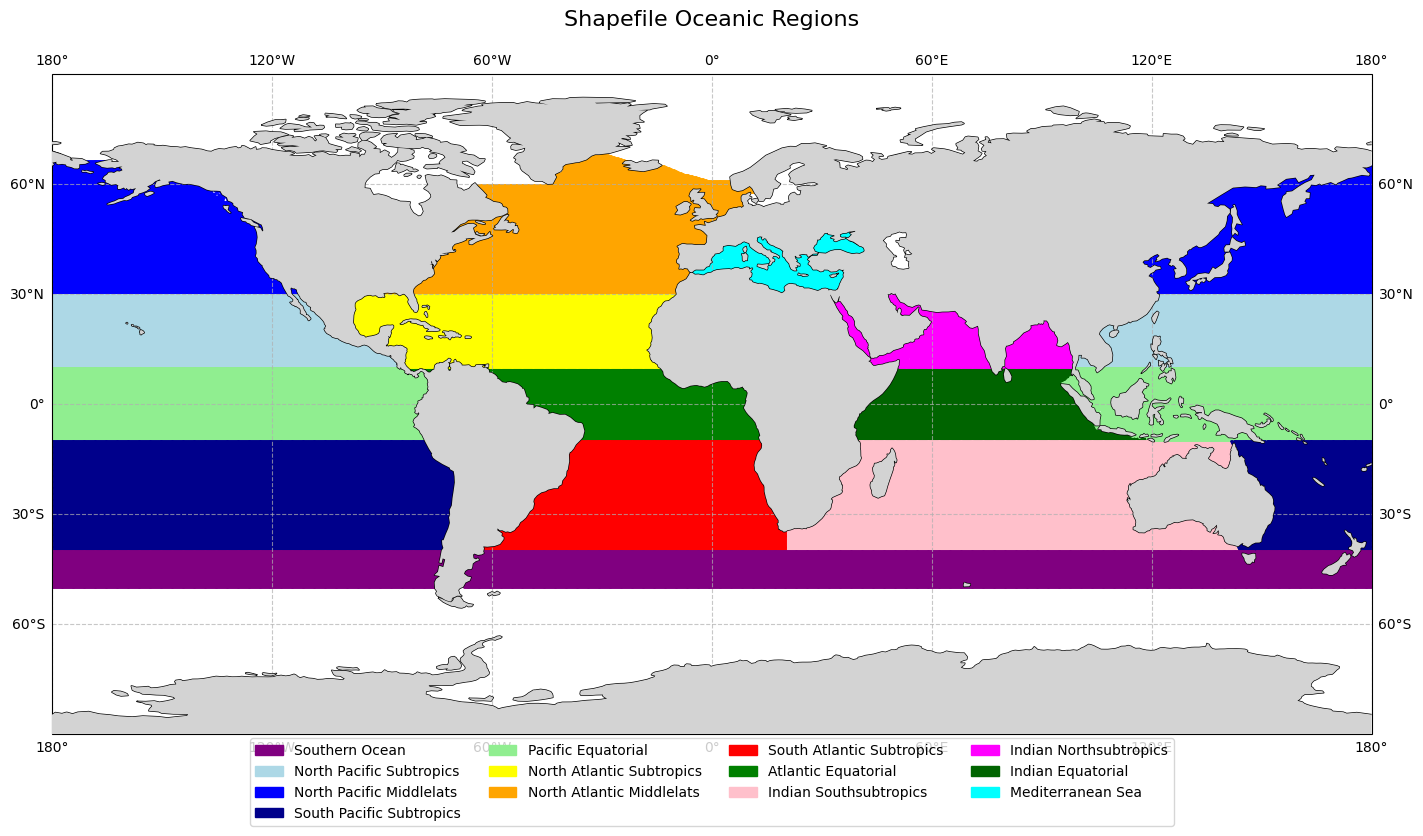

In [7]:

# LATS and LONS for mask
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'OSTIA_pre_1982_2014_shift_hob_maxanom5.zarr'
chunks={'time': 150, 'lat': -1, 'lon': -1} #time=10 for 100GB #time=150 for 512GB
ds_exmp = xr.open_zarr(str(file_name), chunks=chunks)


lats=ds_exmp.lat
lons=ds_exmp.lon

# Old method (coordinate-based)
#masks_old = create_oceanic_regions_mask(lats, lons, method='coordinate')

# Create shapefile masks (no example_sst needed!)
masks = create_oceanic_regions_mask(lats, lons, method='shapefile')

# Or plot directly
fig, ax = plot_shapefile_regions(lats, lons)

# EXTREMES COUNT (days per year)

to select from dataset:
models_dict = {
    'OSTIA': (ds, 'extreme_events'),
    'ICON': (i_ds, 'dat_anomaly'),
    'IFS-FESOM': (f_ds, 'dat_anomaly'),
}

PLOTTING EXTREME EVENT FREQUENCY MAPS
Processing OSTIA...
  Total extreme days: 155,748,522
  Mean frequency: 12.52 days/year
  Max frequency: 84.5 days/year
  Mean value: 12.5 days/year
  High-value contour levels (above mean): [13. 23. 33. 43. 53. 63. 73. 83.]
Processing ICON...
  Total extreme days: 154,317,390
  Mean frequency: 12.38 days/year
  Max frequency: 67.5 days/year
  Mean value: 12.4 days/year
  High-value contour levels (above mean): [13. 23. 33. 43. 53. 63.]
Processing IFS-FESOM...
  Total extreme days: 156,394,995
  Mean frequency: 12.55 days/year
  Max frequency: 84.0 days/year
  Mean value: 12.5 days/year
  High-value contour levels (above mean): [13. 23. 33. 43. 53. 63. 73. 83.]


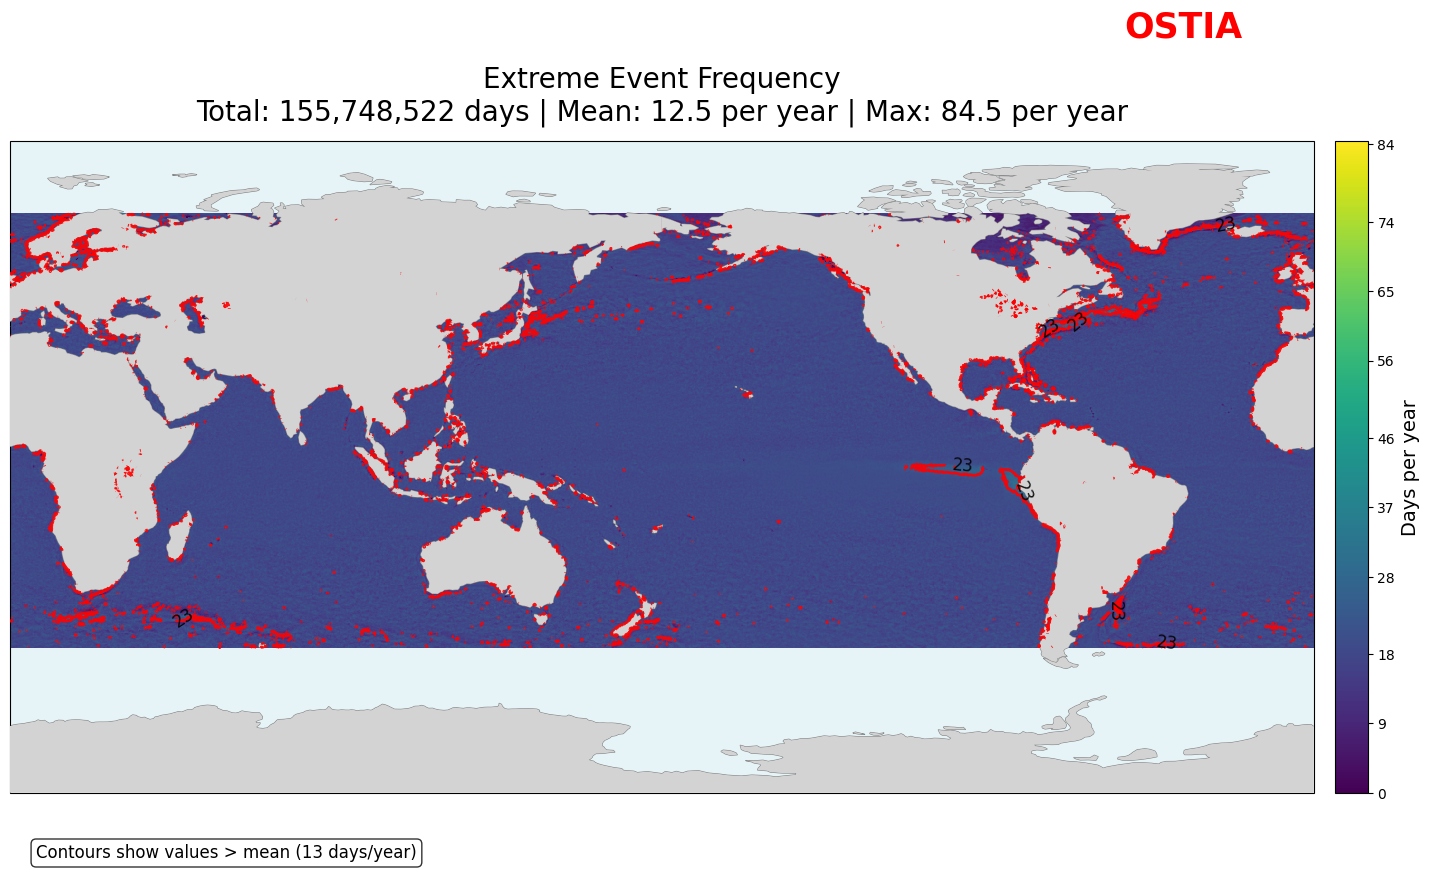

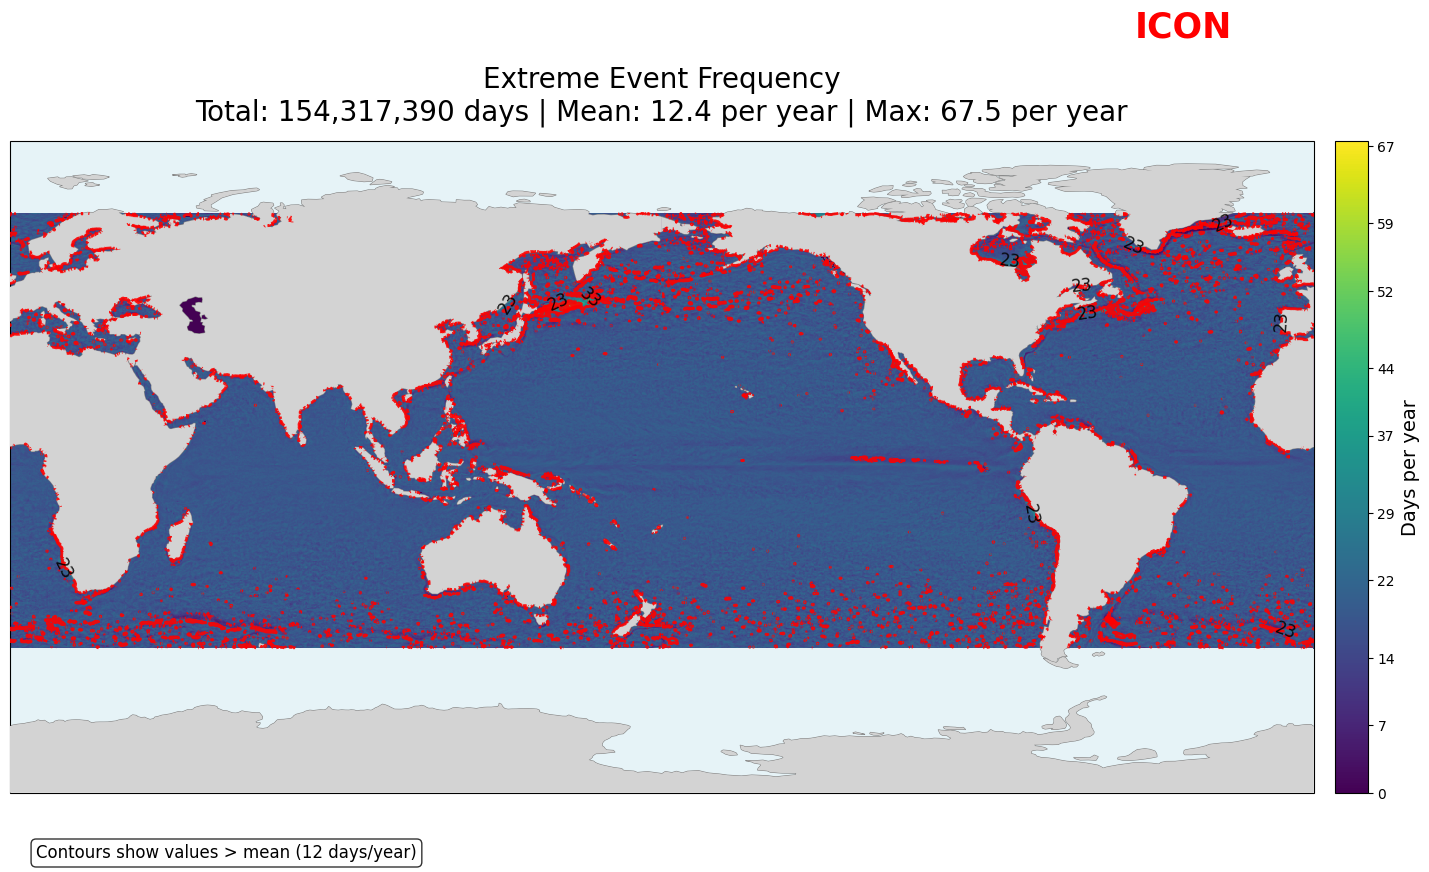

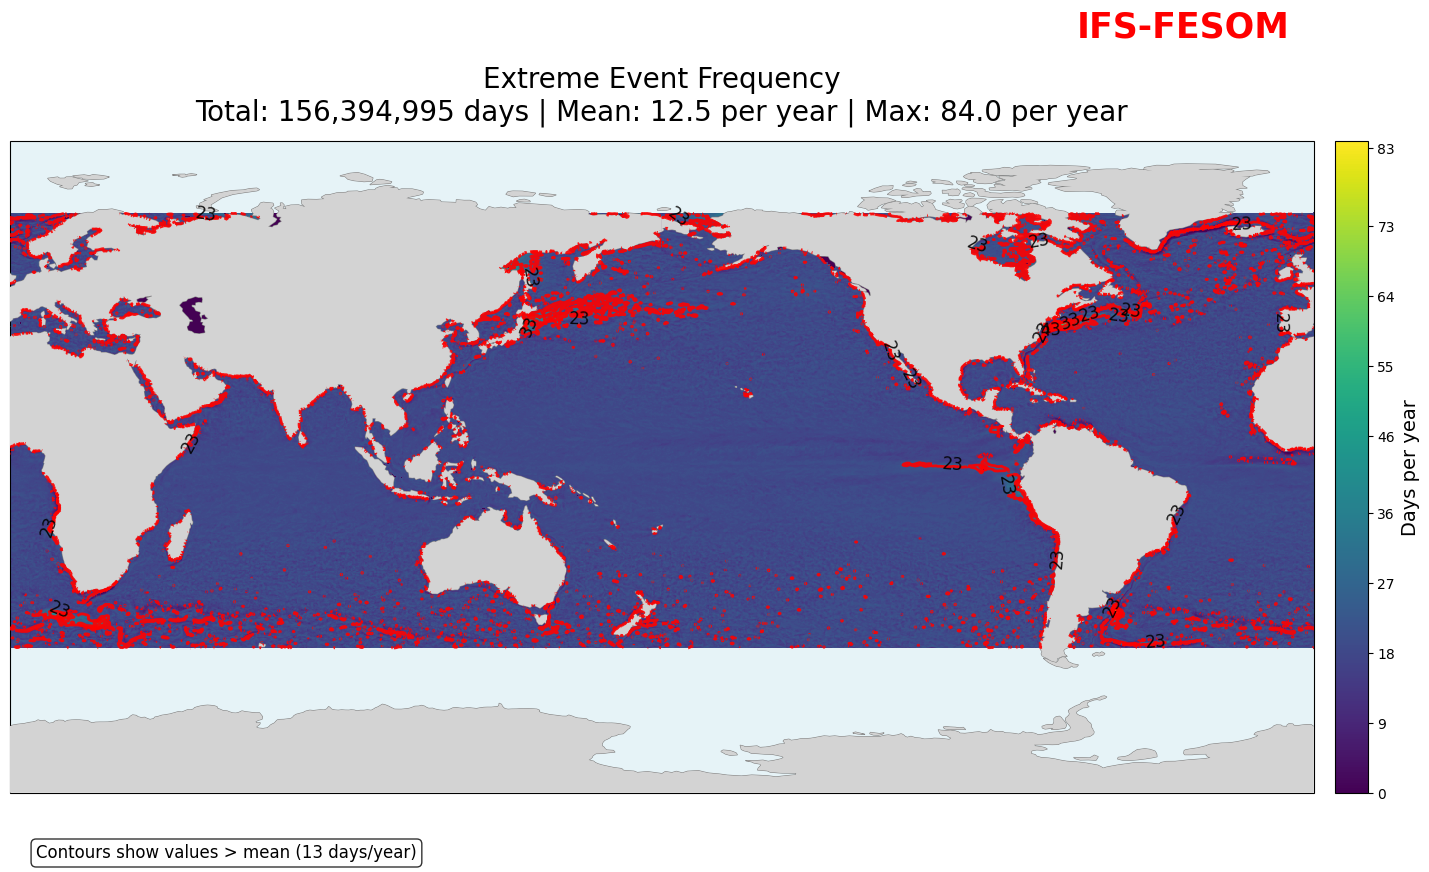

In [11]:
models_extremes = {
    'OSTIA': o_ex,  # direct data array
    'ICON': i_ex,   # direct data array  
    'IFS-FESOM': f_ex,  # direct data array
}


# With default settings (restricted latitude, contours above mean)
frequency_figs = plot_extreme_frequency_maps(models_extremes)


PLOTTING EXTREME EVENT FREQUENCY MAPS
Processing OSTIA...
  Total extreme days: 155,748,522
  Mean frequency: 12.52 days/year
  Max frequency: 84.5 days/year
Processing ICON...
  Total extreme days: 154,317,390
  Mean frequency: 12.38 days/year
  Max frequency: 67.5 days/year
Processing IFS-FESOM...
  Total extreme days: 156,394,995
  Mean frequency: 12.55 days/year
  Max frequency: 84.0 days/year


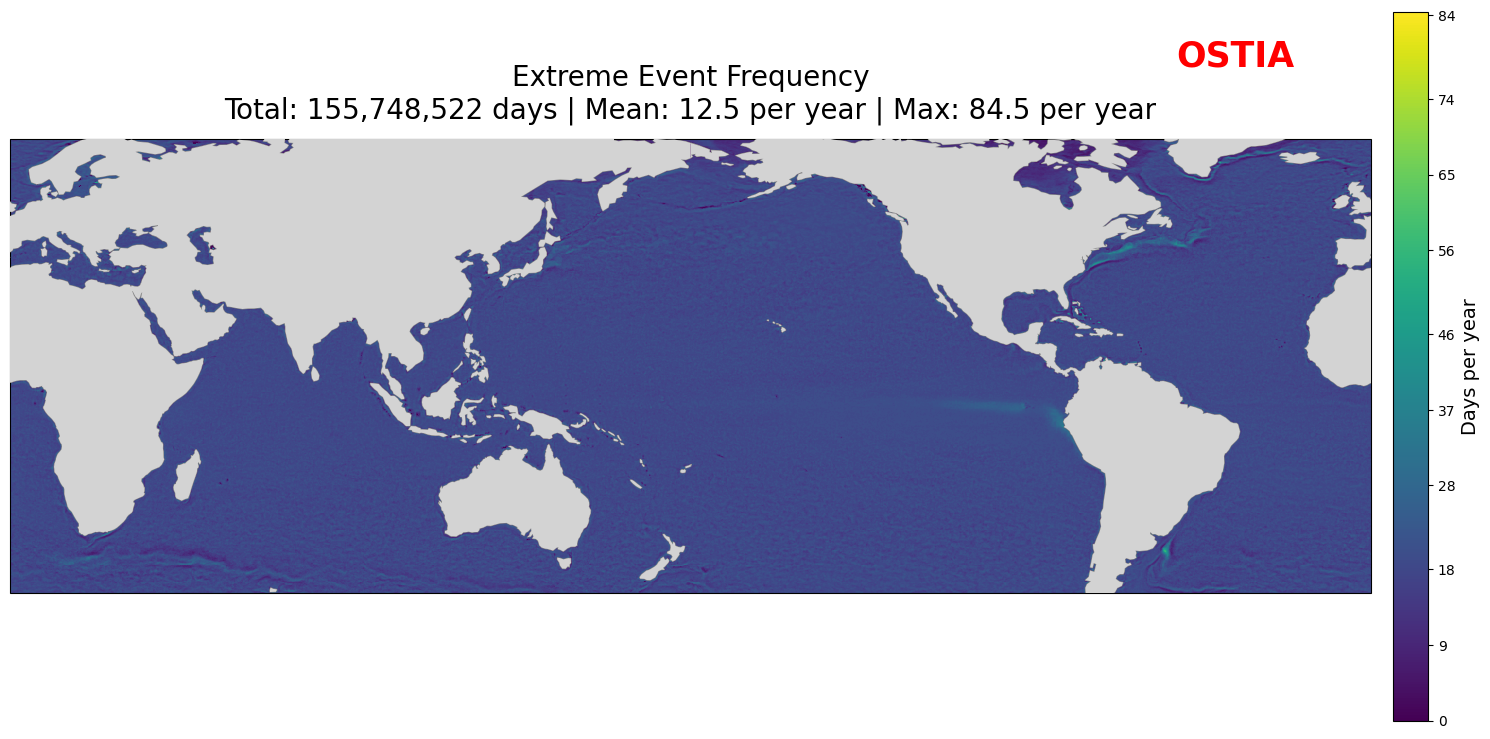

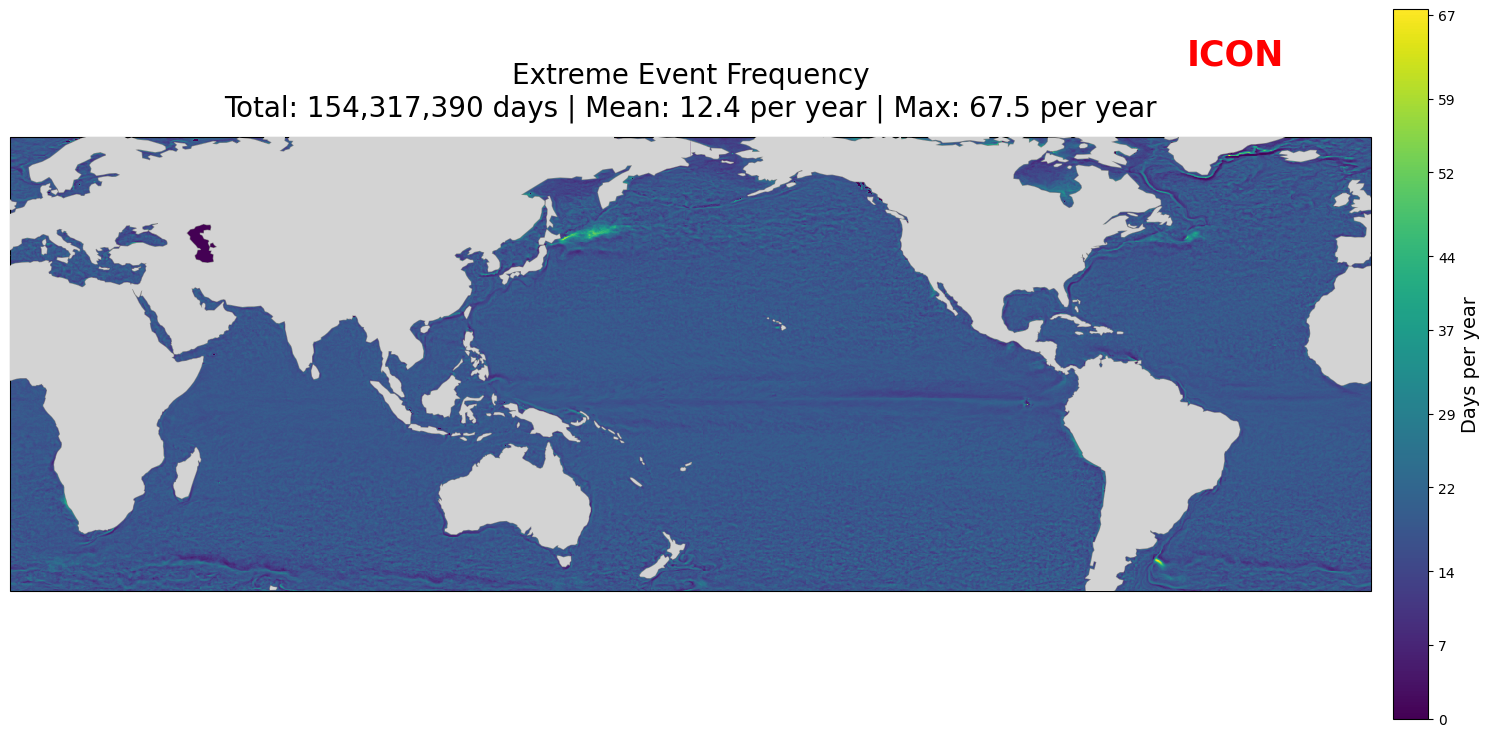

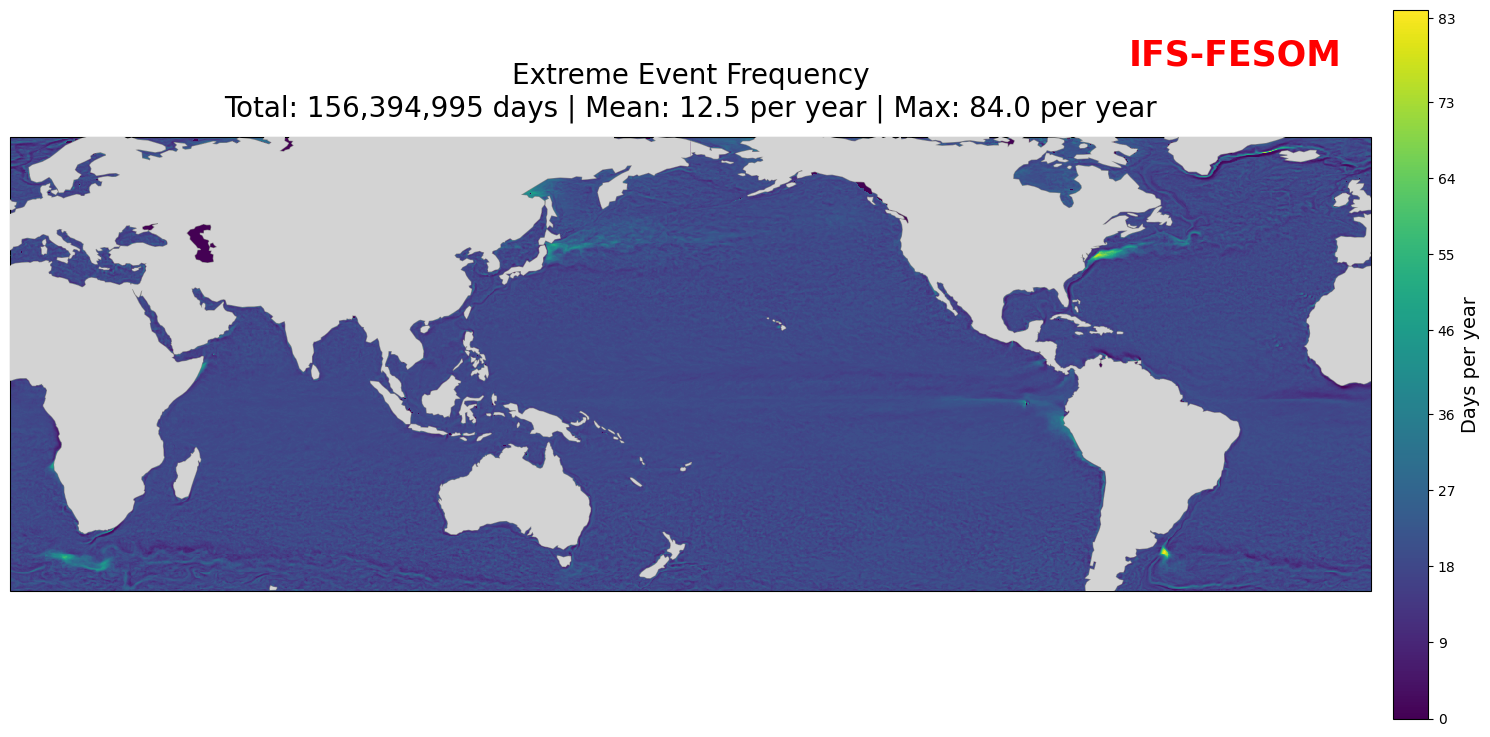

In [12]:

# With custom latitude range and no contours
frequency_figs = plot_extreme_frequency_maps(
    models_extremes,
    lat_range=(-50, 70),           # sea-ice free mask
    contour_above_mean=False,      # No contour lines
    normalize=True
)


QUICK REGIONAL EXTREMES ANALYSIS
COMPUTING REGIONAL EXTREMES
Creating model-specific masks...
Creating masks for OSTIA...
Loading existing masks...
  OSTIA grid: (480,) x (1440,)
Creating masks for ICON...
Loading existing masks...
  ICON grid: (480,) x (1440,)
Creating masks for IFS-FESOM...
Loading existing masks...
  IFS-FESOM grid: (480,) x (1440,)
Processing OSTIA...
  Atlantic_Equatorial: 18.4 days/year/gridcell (16773 grid cells)
  Indian_Equatorial: 18.3 days/year/gridcell (18283 grid cells)
  Indian_NorthSubTropics: 18.3 days/year/gridcell (8252 grid cells)
  Indian_SouthSubTropics: 18.1 days/year/gridcell (44121 grid cells)
  Mediterranean_Sea: 18.5 days/year/gridcell (4899 grid cells)
  North_Atlantic_MiddleLats: 18.3 days/year/gridcell (34313 grid cells)
  North_Atlantic_SubTropics: 18.4 days/year/gridcell (23630 grid cells)
  North_Pacific_MiddleLats: 18.1 days/year/gridcell (49110 grid cells)
  North_Pacific_SubTropics: 18.3 days/year/gridcell (46450 grid cells)
  Pacific

2025-11-10 18:05:28,506 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.89 GiB -- Worker memory limit: 7.81 GiB


  Atlantic_Equatorial: 14.6 days/year/gridcell (16773 grid cells)
  Indian_Equatorial: 14.8 days/year/gridcell (18283 grid cells)
  Indian_NorthSubTropics: 13.6 days/year/gridcell (8252 grid cells)


2025-11-10 18:07:02,404 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.90 GiB -- Worker memory limit: 7.81 GiB


  Indian_SouthSubTropics: 13.6 days/year/gridcell (44121 grid cells)


2025-11-10 18:07:41,051 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.74 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:07:41,365 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.90 GiB -- Worker memory limit: 7.81 GiB


  Mediterranean_Sea: 12.7 days/year/gridcell (4899 grid cells)
  North_Atlantic_MiddleLats: 13.1 days/year/gridcell (34313 grid cells)


2025-11-10 18:08:42,397 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.44 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:08:43,297 - distributed.worker.memory - WARNING - Worker is at 42% memory usage. Resuming worker. Process memory: 3.35 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:08:43,869 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.90 GiB -- Worker memory limit: 7.81 GiB


  North_Atlantic_SubTropics: 14.4 days/year/gridcell (23630 grid cells)


2025-11-10 18:09:18,764 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.44 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:09:18,768 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.44 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:09:19,571 - distributed.worker.memory - WARNING - Worker is at 42% memory usage. Resuming worker. Process memory: 3.35 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:09:30,142 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:35341
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_

  North_Pacific_MiddleLats: 13.4 days/year/gridcell (49110 grid cells)


2025-11-10 18:09:59,382 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.45 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:09:59,383 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.45 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:10:01,099 - distributed.worker.memory - WARNING - Worker is at 13% memory usage. Resuming worker. Process memory: 1.04 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:10:01,794 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

  North_Pacific_SubTropics: 14.6 days/year/gridcell (46450 grid cells)


2025-11-10 18:10:24,416 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.29 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:10:26,233 - distributed.worker.memory - WARNING - Worker is at 41% memory usage. Resuming worker. Process memory: 3.28 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:10:29,877 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.59 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:10:41,253 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memo

  Pacific_Equatorial: 14.1 days/year/gridcell (53415 grid cells)


2025-11-10 18:11:02,432 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.38 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:11:04,687 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33679
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/worker.py", line 2881, in get_data_from_worker
    response = await send_recv(
  File "/home/b/b382616/.local/lib/python3.10

  South_Atlantic_SubTropics: 13.8 days/year/gridcell (29888 grid cells)


2025-11-10 18:11:34,949 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.43 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:11:35,858 - distributed.worker.memory - WARNING - Worker is at 34% memory usage. Resuming worker. Process memory: 2.68 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:11:41,355 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.82 GiB -- Worker memory limit: 7.81 GiB


  South_Pacific_SubTropics: 14.7 days/year/gridcell (66316 grid cells)


2025-11-10 18:12:11,491 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.29 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:12:12,043 - distributed.worker.memory - WARNING - Worker is at 66% memory usage. Resuming worker. Process memory: 5.23 GiB -- Worker memory limit: 7.81 GiB


  Southern_Ocean: 12.2 days/year/gridcell (55792 grid cells)
Processing IFS-FESOM...
  Atlantic_Equatorial: 15.3 days/year/gridcell (16773 grid cells)


2025-11-10 18:13:26,475 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 4.82 GiB -- Worker memory limit: 7.81 GiB


  Indian_Equatorial: 16.0 days/year/gridcell (18283 grid cells)
  Indian_NorthSubTropics: 14.0 days/year/gridcell (8252 grid cells)


2025-11-10 18:14:23,345 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.57 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:14:24,471 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33911
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 228, in read
    frames_nosplit = await read_bytes_rw(stream, frames_nosplit_nbytes)
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 367, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (m

  Indian_SouthSubTropics: 14.4 days/year/gridcell (44121 grid cells)


2025-11-10 18:15:00,081 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.35 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:15:00,495 - distributed.worker.memory - WARNING - Worker is at 33% memory usage. Resuming worker. Process memory: 2.65 GiB -- Worker memory limit: 7.81 GiB


  Mediterranean_Sea: 13.5 days/year/gridcell (4899 grid cells)
  North_Atlantic_MiddleLats: 13.5 days/year/gridcell (34313 grid cells)


2025-11-10 18:16:01,552 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.37 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:16:01,558 - distributed.worker.memory - WARNING - Worker is at 71% memory usage. Resuming worker. Process memory: 5.61 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:16:05,618 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.55 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:16:09,245 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.37 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:16:09,484 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.38 GiB 

  North_Atlantic_SubTropics: 15.0 days/year/gridcell (23630 grid cells)


2025-11-10 18:16:34,919 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 5.78 GiB -- Worker memory limit: 7.81 GiB


  North_Pacific_MiddleLats: 15.4 days/year/gridcell (49110 grid cells)


2025-11-10 18:17:12,377 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.29 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:17:13,999 - distributed.worker.memory - WARNING - Worker is at 67% memory usage. Resuming worker. Process memory: 5.29 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:17:16,396 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:34653
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 228, in read
    frames_nosplit = await read_bytes_rw(stream, frames_nosplit_nbytes)
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 367, in read_bytes_rw
    actual = await stream.read_into(chunk)  # type: ignore[arg-type]
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent ca

  North_Pacific_SubTropics: 15.4 days/year/gridcell (46450 grid cells)


2025-11-10 18:17:36,877 - distributed.worker - ERROR - Worker stream died during communication: tcp://127.0.0.1:33119
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/worker.py", line 2075, in gather_dep
    response = await get_data_from_worker(
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/worker.py", line 2881, in get_data_from_worker
    response = await send_recv(
  File "/home/b/b382616/.local/lib/python3.10/site-packages/distributed/core.py", line 1018, in send_recv
    response = await comm.read(deserializers=deserializers)
  File "/home/b/b382616/.local/lib/python3.10/sit

  Pacific_Equatorial: 16.1 days/year/gridcell (53415 grid cells)
  South_Atlantic_SubTropics: 15.1 days/year/gridcell (29888 grid cells)


2025-11-10 18:18:43,695 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.38 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:18:43,696 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 6.38 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:18:44,669 - distributed.worker.memory - WARNING - Worker is at 32% memory usage. Resuming worker. Process memory: 2.51 GiB -- Worker memory limit: 7.81 GiB


  South_Pacific_SubTropics: 15.7 days/year/gridcell (66316 grid cells)


2025-11-10 18:19:06,946 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.47 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:19:07,593 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.38 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:19:07,595 - distributed.worker.memory - WARNING - Worker is at 42% memory usage. Resuming worker. Process memory: 3.29 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:19:08,237 - distributed.worker.memory - WARNING - Worker is at 44% memory usage. Resuming worker. Process memory: 3.48 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:19:10,521 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 6.27 GiB -- Worker memory limit: 7.81 GiB
2025-11-10 18:19:12,229 - distributed.worker.memory - WARNING - Worker is at 32% memory usage. Resuming worker. Process memory: 2.52 GiB -- Worker mem

  Southern_Ocean: 13.4 days/year/gridcell (55792 grid cells)
PLOTTING REGIONAL EXTREMES BARCHART


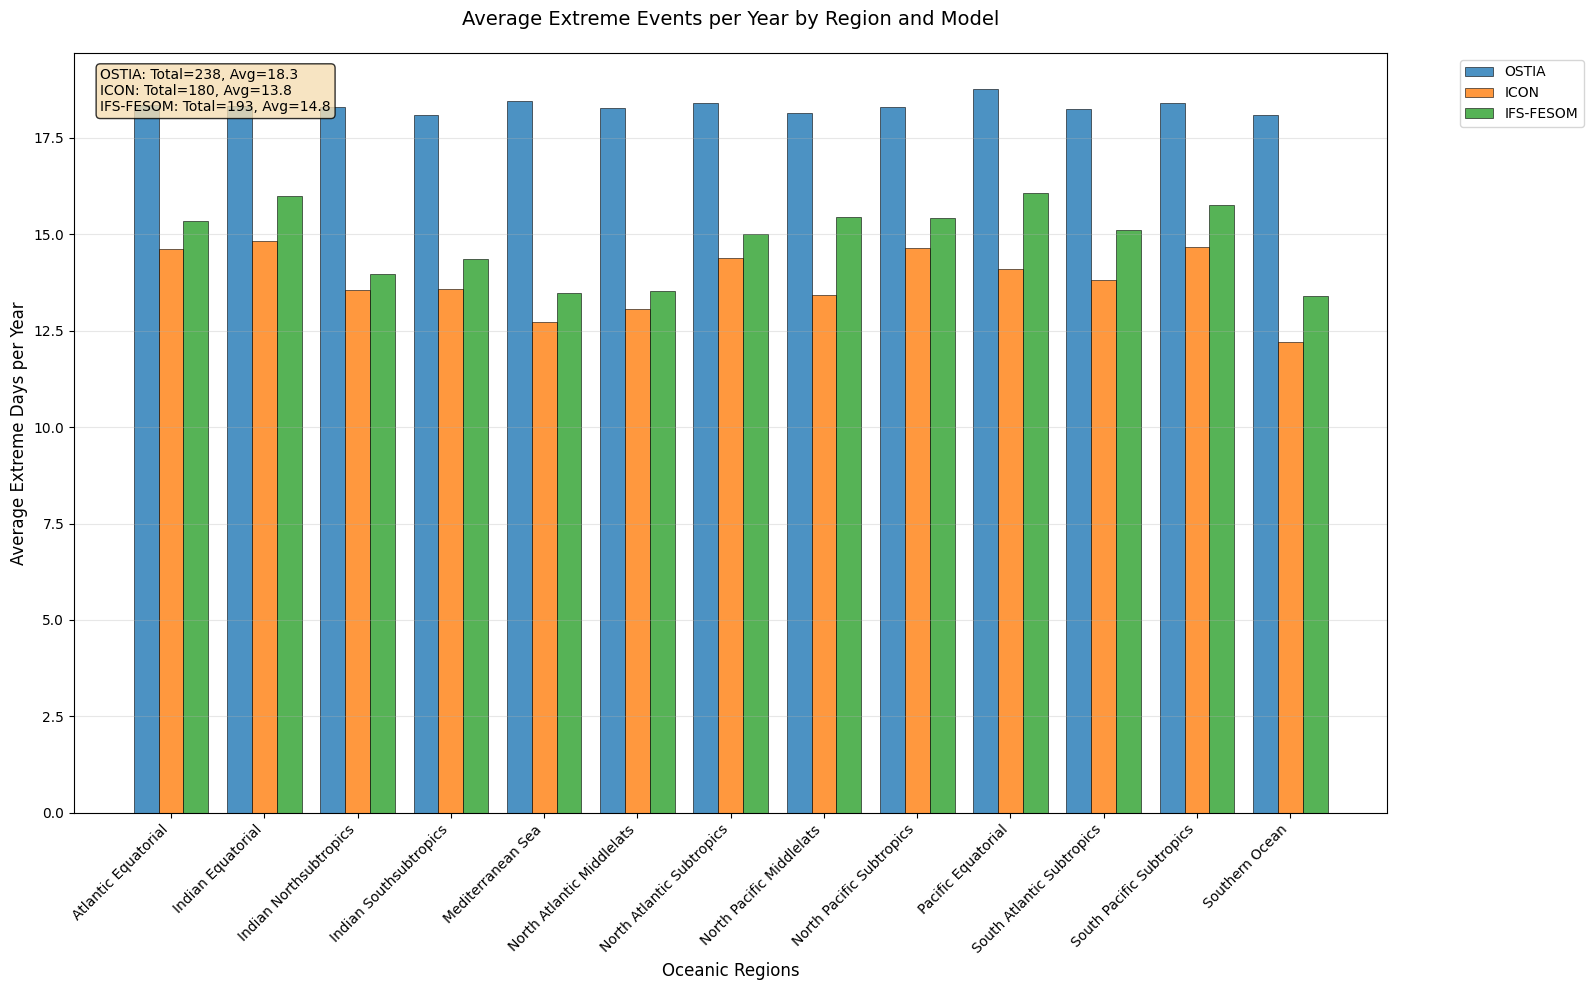

In [9]:
models_extremes = {
    'OSTIA': o_ex,  # direct data array
    'ICON': i_ex,   # direct data array  
    'IFS-FESOM': f_ex,  # direct data array
}

# 1. Quick barchart comparing all models and regions (per grid cell)
fig, ax, regional_data = quick_regional_extremes_analysis(
    models_extremes,
    plot_type='barchart',
    per_grid_cell=True  # Now this will work!
)


In [ ]:

# 2. Heatmap view (per grid cell)
fig, ax, regional_data = quick_regional_extremes_analysis(
    models_extremes,
    plot_type='heatmap',
    cmap='viridis',
    per_grid_cell=True
)

# 3. If you want regional totals instead (not per grid cell)
fig, ax, regional_data = quick_regional_extremes_analysis(
    models_extremes,
    plot_type='barchart', 
    per_grid_cell=False  # Get regional totals
)

In [ ]:
# 3. Single model analysis
fig, ax, regional_data = quick_regional_extremes_analysis(
    models_extremes,
    plot_type='single'  # Will plot the first model
)

# 4. Specific model regional analysis
regional_data, masks = compute_regional_extremes(models_extremes)
fig, ax = plot_regional_comparison_single_model(
    regional_data, 
    'OSTIA',
    color='coral',
    title_template="Regional MHW Frequency - {}"
)

# 5. Comprehensive analysis with all plots
figs, axes, regional_data = quick_all_regional_plots(
    models_extremes,
    regions=['Pacific_Equatorial', 'North_Atlantic_SubTropics', 'Southern_Ocean']  # Optional: specific regions
)

plt.show()